# Import libaries and Data

In [769]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, f1_score,accuracy_score, precision_score, recall_score, confusion_matrix,classification_report
from sklearn.linear_model import LassoCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge

In [723]:

df = pd.read_csv("../additional_material/housing.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Clean Data

In [724]:
# Check how many missing values each column has
df.isna().sum().sort_values(ascending=False).head(20)


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageFinish      81
GarageType        81
GarageYrBlt       81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
Condition2         0
dtype: int64

In [725]:
# Calculate percentage of missing values
missing_pct = df.isna().mean().sort_values(ascending=False) * 100
missing_pct.head(20)


PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
MasVnrType      59.726027
FireplaceQu     47.260274
LotFrontage     17.739726
GarageQual       5.547945
GarageFinish     5.547945
GarageType       5.547945
GarageYrBlt      5.547945
GarageCond       5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtCond         2.534247
BsmtQual         2.534247
BsmtFinType1     2.534247
MasVnrArea       0.547945
Electrical       0.068493
Condition2       0.000000
dtype: float64

In [726]:
# Drop variables that have extremely high missing values
vars_to_drop = ["PoolQC", "MiscFeature", "Alley"]

df = df.drop(columns=vars_to_drop)

In [727]:
# Handle remaining missing values: 

# -----------------------------
# 1. Replace missing values with explicit categories
# -----------------------------

# Fence -> NoFence
df["Fence"] = df["Fence"].fillna("NoFence")

# MasVnrType -> None
df["MasVnrType"] = df["MasVnrType"].fillna("None")

# FireplaceQu -> NoFireplace
df["FireplaceQu"] = df["FireplaceQu"].fillna("NoFireplace")

# LotFrontage -> 0
# Comment: LotFrontage is numeric, so we fill with 0
df["LotFrontage"] = df["LotFrontage"].fillna(0)

# Garage-related variables -> NoGarage
garage_cols = [
    "GarageQual",
    "GarageFinish",
    "GarageType",
    "GarageYrBlt",
    "GarageCond"
]

for col in garage_cols:
    df[col] = df[col].fillna(0 if col == "GarageYrBlt" else "NoGarage")
  

# Basement-related variables -> NoBasement
basement_cols = [
    "BsmtFinType2",
    "BsmtExposure",
    "BsmtCond",
    "BsmtQual",
    "BsmtFinType1"
]

for col in basement_cols:
    df[col] = df[col].fillna("NoBasement")

# -----------------------------
# 2. Drop rows with missing values in specific columns
# -----------------------------

# Drop rows where MasVnrArea is missing
df = df.dropna(subset=["MasVnrArea"])

# Drop rows where Electrical is missing
df = df.dropna(subset=["Electrical"])


In [728]:
# Check again how many missing values each column has
df.isna().sum().sort_values(ascending=False).head(20)

Id              0
MSSubClass      0
MSZoning        0
LotFrontage     0
LotArea         0
Street          0
LotShape        0
LandContour     0
Utilities       0
LotConfig       0
LandSlope       0
Neighborhood    0
Condition1      0
Condition2      0
BldgType        0
HouseStyle      0
OverallQual     0
OverallCond     0
YearBuilt       0
YearRemodAdd    0
dtype: int64

In [729]:
# Check for duplicate rows
df.duplicated().sum()


np.int64(0)

# Inspect the target variable

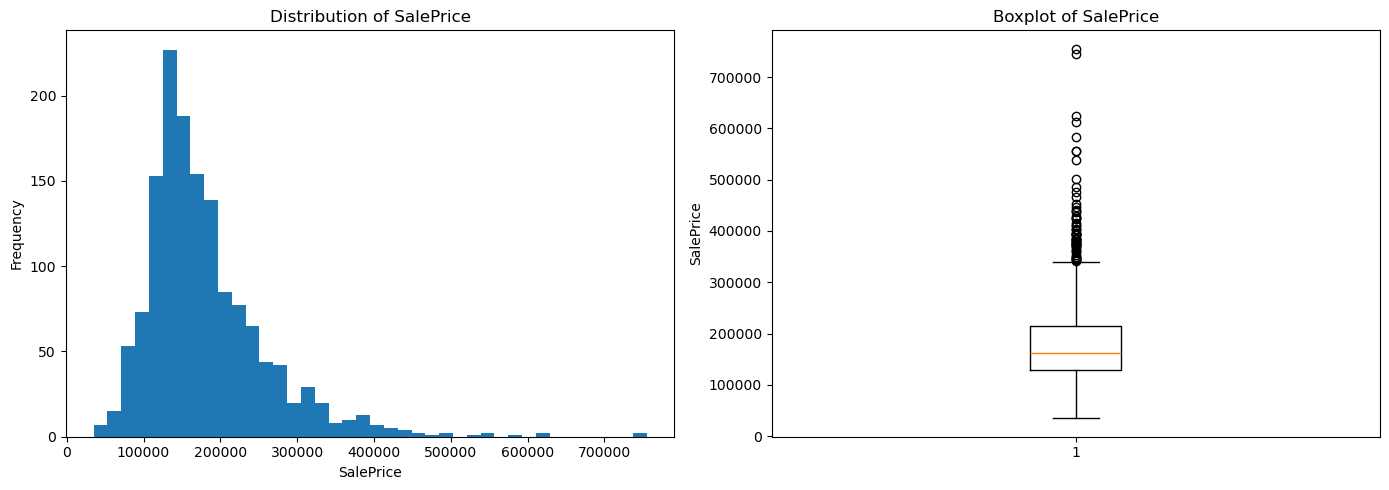

In [730]:
# Create a figure with two subplots (histogram + boxplot)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Histogram ---
axes[0].hist(df["SalePrice"], bins=40)
axes[0].set_title("Distribution of SalePrice")
axes[0].set_xlabel("SalePrice")
axes[0].set_ylabel("Frequency")

# --- Boxplot ---
# Boxplots help to detect outliers visually
axes[1].boxplot(df["SalePrice"], vert=True)
axes[1].set_title("Boxplot of SalePrice")
axes[1].set_ylabel("SalePrice")

plt.tight_layout()
plt.show()

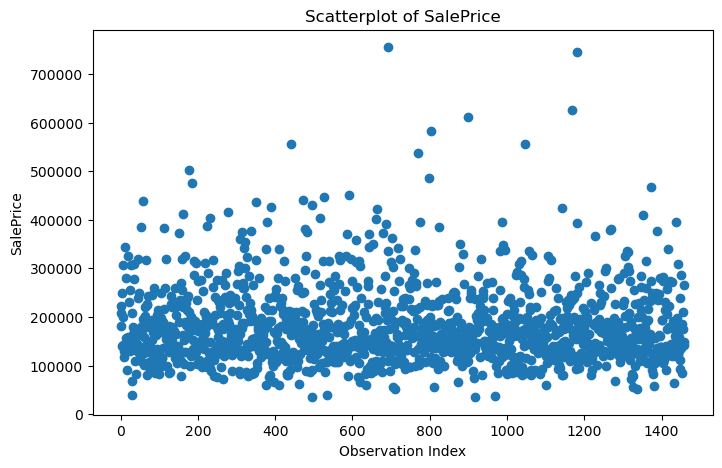

In [731]:


# Comment: Create a scatter plot of SalePrice against the observation index
plt.figure(figsize=(8, 5))

plt.scatter(df.index, df["SalePrice"])
plt.xlabel("Observation Index")
plt.ylabel("SalePrice")
plt.title("Scatterplot of SalePrice")

plt.show()


# Check for multicollonearity


## Numerical variables

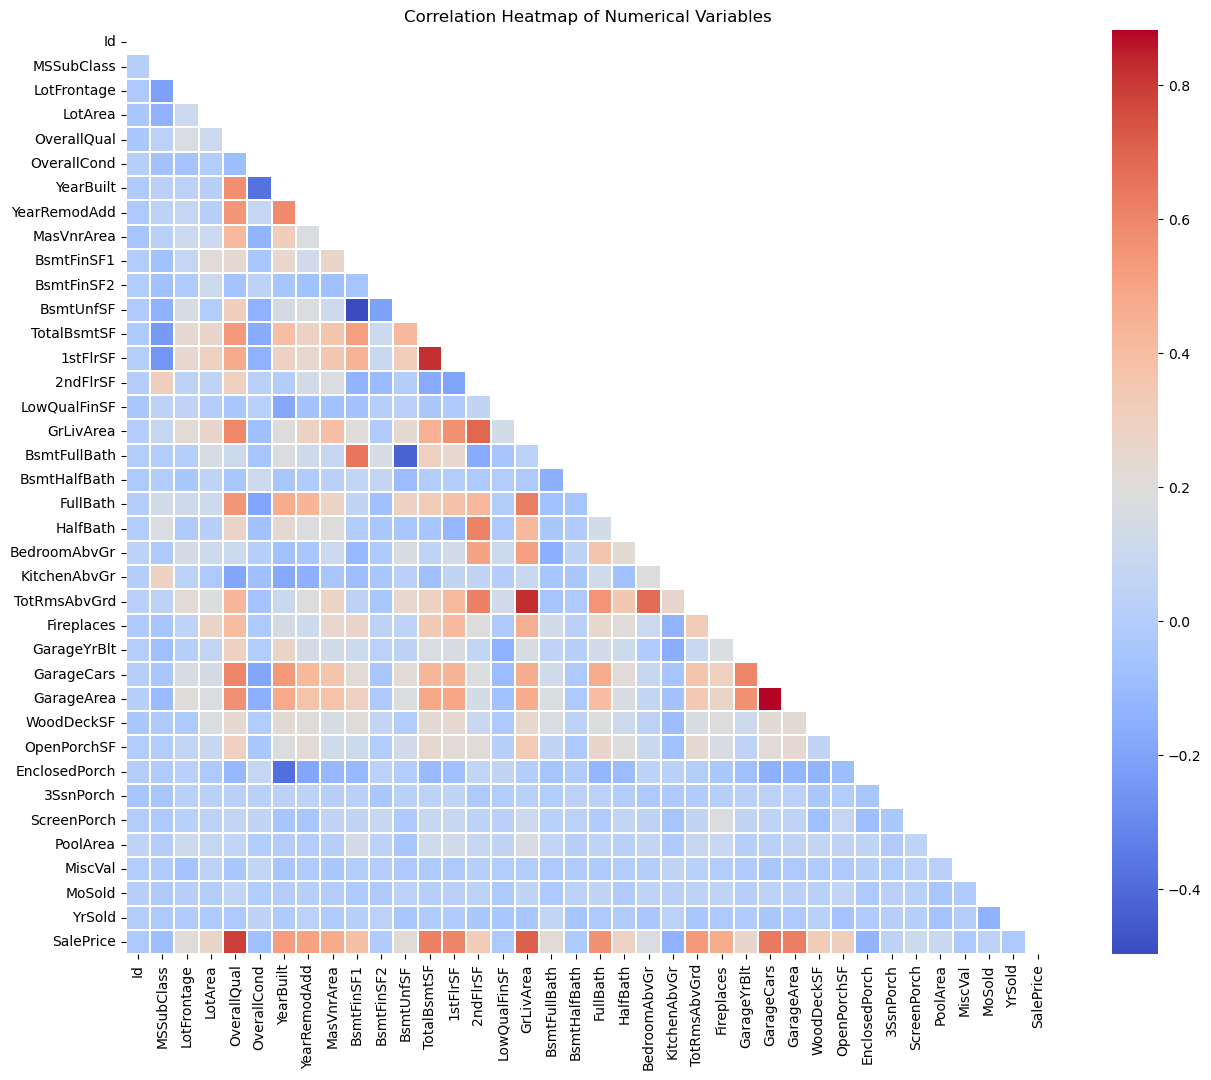

In [732]:


# --- Select only numerical columns ---
# Comment: This filters the dataframe to numeric variables only
numeric_df = df.select_dtypes(include=["int64", "float64"])

# --- Compute correlation matrix ---
corr_matrix = numeric_df.corr()

# --- Plot the heatmap ---
plt.figure(figsize=(16, 12))

# Comment: Using a mask hides the upper triangle of the heatmap to make it easier to read
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap="coolwarm",
    annot=False,
    fmt=".2f",
    square=True,
    linewidths=0.3
)

plt.title("Correlation Heatmap of Numerical Variables")
plt.show()


## Exclude variables that have basically no correlation with SalePrice to pre-reduce the model

In [733]:


# --- Select only numeric columns ---
numeric_df = df.select_dtypes(include=["int64", "float64"])

# --- Compute Spearman correlation matrix ---
spearman_corr = numeric_df.corr(method="spearman")

# --- Extract correlations with SalePrice ---
saleprice_corr = (
    spearman_corr["SalePrice"]
    .drop("SalePrice")              # remove self-correlation
    .sort_values(ascending=False)   # sort by strength
)

saleprice_corr


OverallQual      0.809477
GrLivArea        0.731096
GarageCars       0.690073
YearBuilt        0.652576
GarageArea       0.648808
FullBath         0.635896
GarageYrBlt      0.633518
TotalBsmtSF      0.603145
1stFlrSF         0.576567
YearRemodAdd     0.570768
TotRmsAbvGrd     0.533715
Fireplaces       0.521201
OpenPorchSF      0.476978
LotArea          0.457572
MasVnrArea       0.421500
WoodDeckSF       0.355873
HalfBath         0.341811
BsmtFinSF1       0.299852
2ndFlrSF         0.294484
LotFrontage      0.238625
BedroomAbvGr     0.237407
BsmtFullBath     0.222735
BsmtUnfSF        0.185559
ScreenPorch      0.102026
MoSold           0.069500
3SsnPorch        0.066324
PoolArea         0.058939
MSSubClass       0.008619
BsmtHalfBath    -0.010623
Id              -0.020577
YrSold          -0.029375
BsmtFinSF2      -0.036965
MiscVal         -0.061938
LowQualFinSF    -0.067301
OverallCond     -0.126816
KitchenAbvGr    -0.167833
EnclosedPorch   -0.219356
Name: SalePrice, dtype: float64

## All variables with a correlation between -0.1 and 0.1 will be excluded as they are most likely very irrelevant

In [734]:
# Comment: Drop numeric predictors with weak Spearman correlation to SalePrice
threshold = 0.10

weak_vars = saleprice_corr[abs(saleprice_corr) < threshold].index.tolist()
weak_vars


['MoSold',
 '3SsnPorch',
 'PoolArea',
 'MSSubClass',
 'BsmtHalfBath',
 'Id',
 'YrSold',
 'BsmtFinSF2',
 'MiscVal',
 'LowQualFinSF']

In [735]:
# Comment: Remove weak numeric predictors from the dataframe
df = df.drop(columns=weak_vars)


In [736]:
print("Dropped variables (|spearman| < 0.10):", weak_vars)


Dropped variables (|spearman| < 0.10): ['MoSold', '3SsnPorch', 'PoolArea', 'MSSubClass', 'BsmtHalfBath', 'Id', 'YrSold', 'BsmtFinSF2', 'MiscVal', 'LowQualFinSF']


## Summarize high-correlating variables to further pre-simplify the model

In [737]:


# --- Select only numeric columns ---
numeric_df = df.select_dtypes(include=["int64", "float64"])

# --- Compute correlation matrix ---
corr_matrix = numeric_df.corr().abs()  # absolute value of correlations

# --- Find pairs with correlation > 0.8 ---
# Comment: We remove self-correlations using a mask
high_corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()  # convert matrix to long format
    .reset_index()
)

# Rename columns for clarity
high_corr_pairs.columns = ["Variable_1", "Variable_2", "Correlation"]

# Filter for correlations above threshold
result = high_corr_pairs[high_corr_pairs["Correlation"] > 0.8]

result


,Variable_1,Variable_2,Correlation
207,TotalBsmtSF,1stFlrSF,0.818107
263,GrLivArea,TotRmsAbvGrd,0.825563
357,GarageCars,GarageArea,0.882470


## We will keep TotalBsmtSF, GrLivArea and GarageCars and dropp the respective other variables as the three we keep have higher correlations with SalePrice

In [738]:
# Comment: Drop redundant numerical variables based on lower correlation with SalePrice
vars_to_drop = [
    "1stFlrSF",
    "TotRmsAbvGrd",
    "GarageArea"
]

df = df.drop(columns=vars_to_drop)


## Correlation Heatmap with final numerical variables for the model

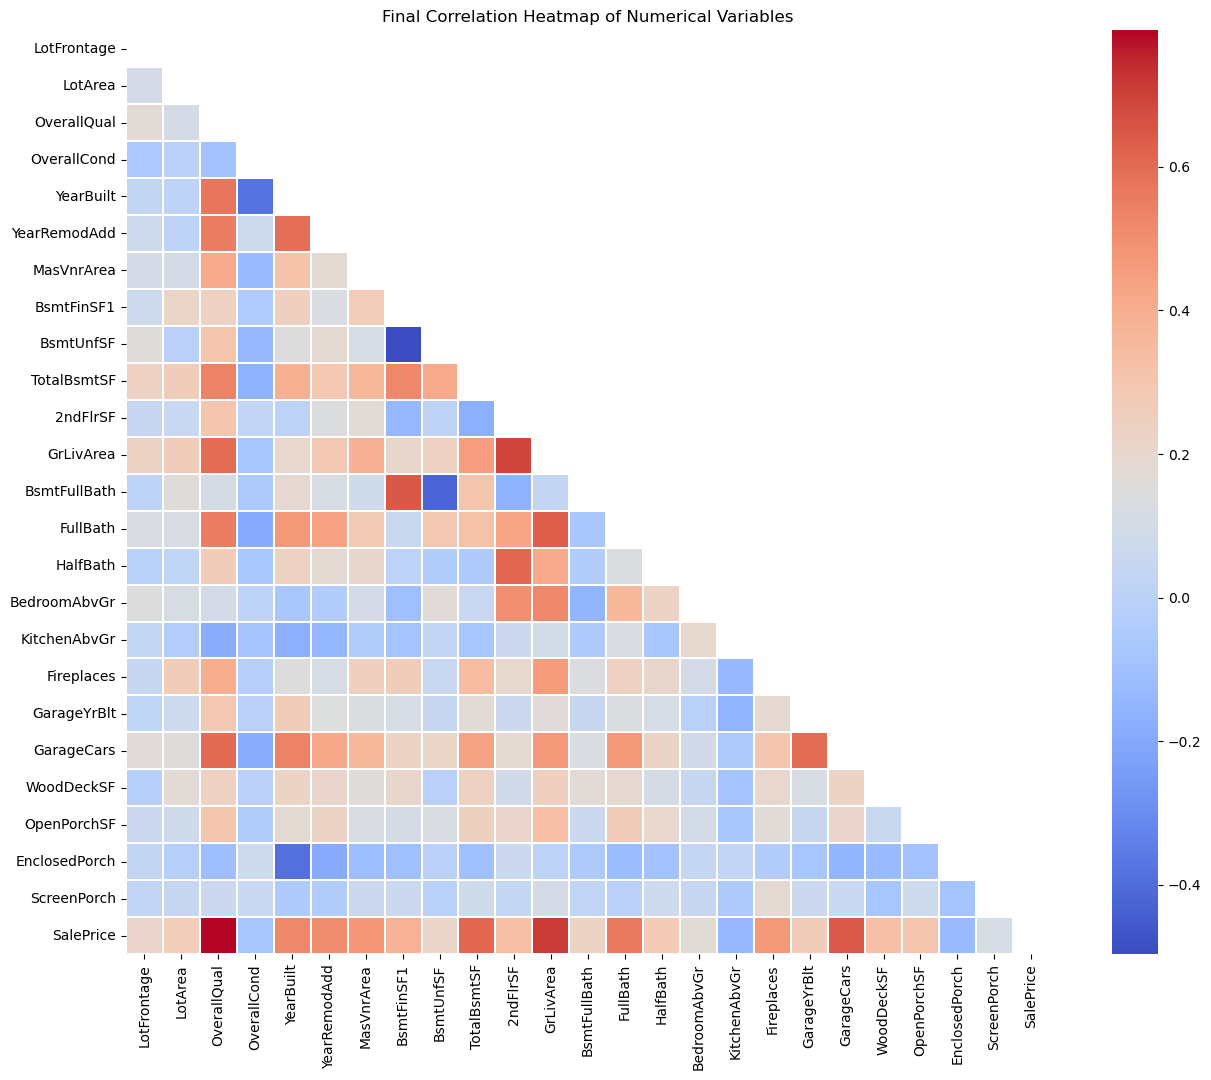

In [739]:
# --- Select final numerical variables ---
# Comment: Select only numerical columns after variable reduction
numeric_df_final = df.select_dtypes(include=["int64", "float64"])

# --- Compute correlation matrix ---
corr_matrix_final = numeric_df_final.corr()

# --- Create mask for upper triangle ---
mask = np.triu(np.ones_like(corr_matrix_final, dtype=bool))

# --- Plot heatmap ---
plt.figure(figsize=(16, 12))

sns.heatmap(
    corr_matrix_final,
    mask=mask,
    cmap="coolwarm",
    annot=False,
    linewidths=0.3,
    square=True
)

plt.title("Final Correlation Heatmap of Numerical Variables")
plt.show()


## Categorical variables

In [740]:


# Comment: Select categorical columns
cat_cols = df.select_dtypes(include=["object", "category"]).columns

results = []

for col in cat_cols:
    # Comment: Calculate median SalePrice per category
    medians = df.groupby(col)["SalePrice"].median()
    
    # Comment: Use range of medians as a simple "impact" measure
    impact = medians.max() - medians.min()
    
    # Comment: Store number of categories and smallest group size (for balance check)
    value_counts = df[col].value_counts()
    min_group_size = value_counts.min()
    n_categories = value_counts.shape[0]
    
    results.append({
        "variable": col,
        "impact_median_range": impact,
        "n_categories": n_categories,
        "min_group_size": min_group_size
    })

cat_impact_df = pd.DataFrame(results).sort_values("impact_median_range", ascending=False)
cat_impact_df


,variable,impact_median_range,n_categories,min_group_size
17,ExterQual,279669.0,4,14
9,Condition2,228250.0,8,1
7,Neighborhood,226906.5,25,2
20,BsmtQual,215700.0,5,35
15,Exterior2nd,214000.0,16,1
29,KitchenQual,200500.0,4,39
13,RoofMatl,195500.0,8,1
14,Exterior1st,191000.0,15,1
31,FireplaceQu,182750.0,6,20
38,SaleType,153550.0,9,2


## One important problem is that some categories have extremely low values (n = 1). We will deal with this by creating a "other" variable to merge some of these together.

In [741]:
# Comment: Select categorical columns
cat_cols = df.select_dtypes(include=["object", "category"]).columns

# Minimum number of observations per category
min_count = 5

for col in cat_cols:
    # Count category frequencies
    value_counts = df[col].value_counts()
    
    # Identify rare categories
    rare_categories = value_counts[value_counts < min_count].index
    
    # Replace rare categories with 'Other'
    df[col] = df[col].replace(rare_categories, "Other")


In [742]:
df[cat_cols].nunique().sort_values()


Street            2
Utilities         2
CentralAir        2
LandSlope         3
Condition2        3
PavedDrive        3
MasVnrType        4
LandContour       4
ExterQual         4
Heating           4
KitchenQual       4
Electrical        4
ExterCond         4
LotShape          4
GarageFinish      4
RoofMatl          5
HeatingQC         5
BsmtExposure      5
BsmtCond          5
BsmtQual          5
BldgType          5
Fence             5
LotConfig         5
MSZoning          5
GarageQual        5
RoofStyle         6
GarageCond        6
SaleCondition     6
FireplaceQu       6
Foundation        6
BsmtFinType2      7
BsmtFinType1      7
GarageType        7
Functional        7
SaleType          7
HouseStyle        8
Condition1        9
Exterior1st      11
Exterior2nd      13
Neighborhood     25
dtype: int64

## okay, now let us run the previous test again:

In [743]:
# Comment: Select categorical columns
cat_cols = df.select_dtypes(include=["object", "category"]).columns

results = []

for col in cat_cols:
    # Comment: Calculate median SalePrice per category
    medians = df.groupby(col)["SalePrice"].median()
    
    # Comment: Use range of medians as a simple "impact" measure
    impact = medians.max() - medians.min()
    
    # Comment: Store number of categories and smallest group size (for balance check)
    value_counts = df[col].value_counts()
    min_group_size = value_counts.min()
    n_categories = value_counts.shape[0]
    
    results.append({
        "variable": col,
        "impact_median_range": impact,
        "n_categories": n_categories,
        "min_group_size": min_group_size
    })

cat_impact_df = pd.DataFrame(results).sort_values("impact_median_range", ascending=False)
cat_impact_df

,variable,impact_median_range,n_categories,min_group_size
17,ExterQual,279669.0,4,14
7,Neighborhood,226906.5,25,2
20,BsmtQual,215700.0,5,35
29,KitchenQual,200500.0,4,39
31,FireplaceQu,182750.0,6,20
13,RoofMatl,171000.0,5,4
39,SaleCondition,141589.0,6,4
14,Exterior1st,136000.0,11,7
15,Exterior2nd,134500.0,13,7
0,MSZoning,133200.0,5,10


## We will drop all variables with impact_median_range < 50.000 as they have lowest impact on SalePrice

In [744]:
# Comment: Define impact threshold
impact_threshold = 50000

# Comment: Identify low-impact categorical variables
low_impact_cats = cat_impact_df.loc[
    cat_impact_df["impact_median_range"] < impact_threshold,
    "variable"
].tolist()

low_impact_cats


['Street',
 'BldgType',
 'Fence',
 'LotConfig',
 'Condition2',
 'LandSlope',
 'Utilities']

<Figure size 800x400 with 0 Axes>

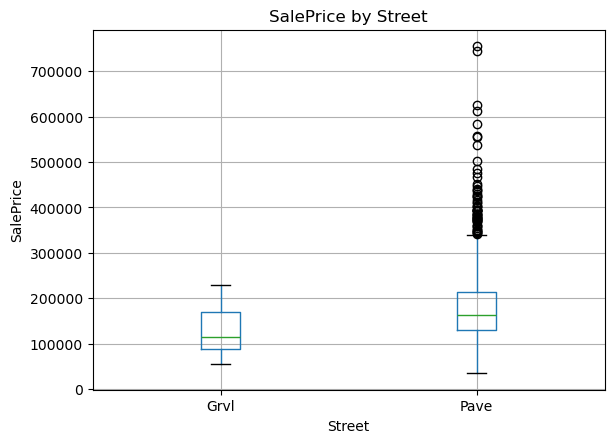

<Figure size 800x400 with 0 Axes>

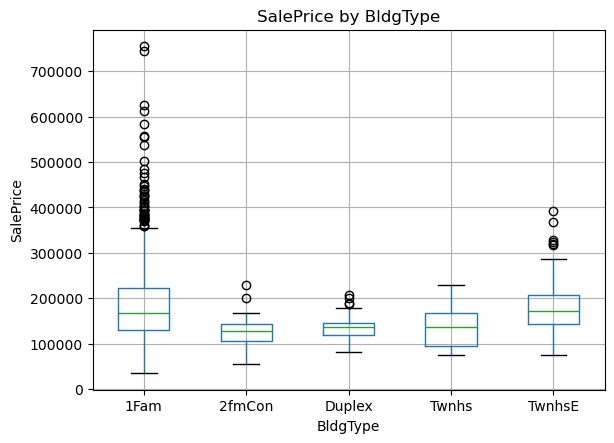

<Figure size 800x400 with 0 Axes>

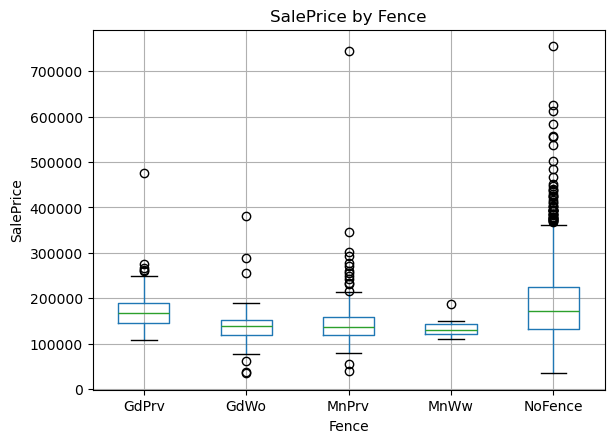

<Figure size 800x400 with 0 Axes>

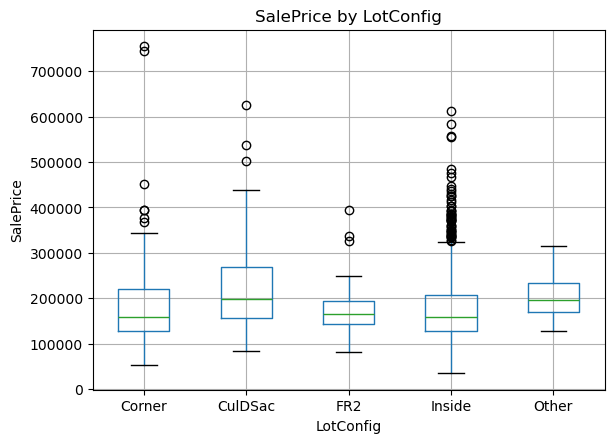

<Figure size 800x400 with 0 Axes>

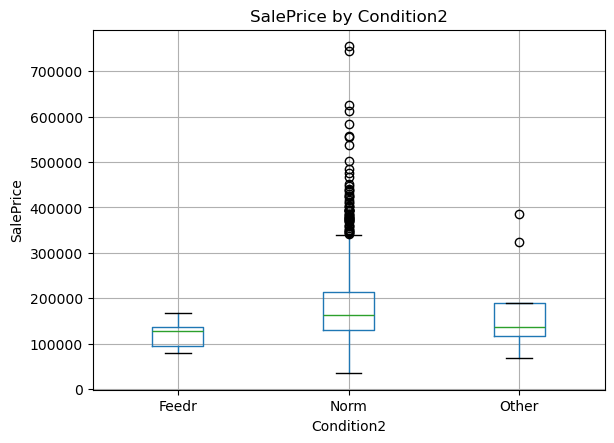

<Figure size 800x400 with 0 Axes>

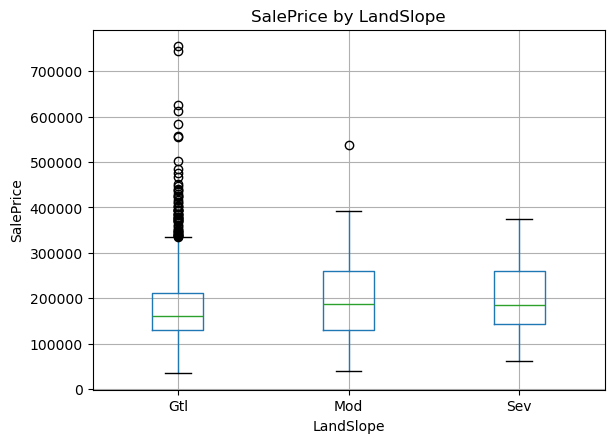

<Figure size 800x400 with 0 Axes>

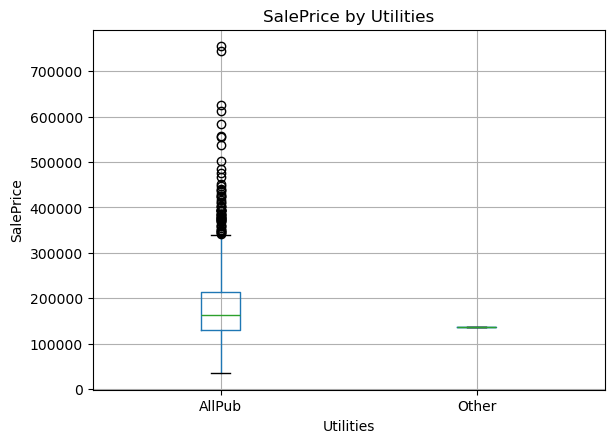

In [745]:

# Comment: Categorical variables to visually inspect before dropping
low_impact_vars = [
    "Street",
    "BldgType",
    "Fence",
    "LotConfig",
    "Condition2",
    "LandSlope",
    "Utilities"
]

# Comment: Create boxplots for each variable
for col in low_impact_vars:
    if col in df.columns:
        plt.figure(figsize=(8, 4))
        
        df.boxplot(column="SalePrice", by=col)
        
        plt.title(f"SalePrice by {col}")
        plt.suptitle("")  # remove automatic pandas subtitle
        plt.xlabel(col)
        plt.ylabel("SalePrice")
        
        plt.show()


In [746]:
print("Dropping categorical variables due to low impact:")
for var in low_impact_cats:
    print("-", var)


Dropping categorical variables due to low impact:
- Street
- BldgType
- Fence
- LotConfig
- Condition2
- LandSlope
- Utilities


In [747]:
# Comment: Drop low-impact categorical variables from the dataframe
df = df.drop(columns=low_impact_cats)


## Testing similar categorical variables whether some are redundandant

In [748]:
from scipy.stats import chi2_contingency
import itertools

def cramers_v(x, y):
    """Calculate Cramér's V for two categorical variables."""
    confusion_matrix = pd.crosstab(x, y)
    chi2, p, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.values.sum()
    r, k = confusion_matrix.shape
    # bias correction (optional but nice)
    phi2 = chi2 / n
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / max(1e-12, min((kcorr-1), (rcorr-1))))

# --- Define "conceptual blocks" of variables (edit to match your remaining columns) ---
blocks = {
    "Garage": ["GarageType", "GarageFinish", "GarageQual", "GarageCond"],
    "Basement": ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"],
    "Exterior": ["ExterQual", "ExterCond", "Exterior1st", "Exterior2nd"],
    "Sale": ["SaleType", "SaleCondition"],
    "Location": ["Neighborhood", "MSZoning", "Condition1"]
}

results = []

for block_name, vars_list in blocks.items():
    # Keep only variables that still exist in df
    vars_list = [v for v in vars_list if v in df.columns]
    for v1, v2 in itertools.combinations(vars_list, 2):
        v = cramers_v(df[v1], df[v2])
        results.append({
            "block": block_name,
            "var1": v1,
            "var2": v2,
            "cramers_v": v
        })

assoc_df = pd.DataFrame(results).sort_values("cramers_v", ascending=False)
assoc_df


,block,var1,var2,cramers_v
21,Exterior,Exterior1st,Exterior2nd,0.805967
5,Garage,GarageQual,GarageCond,0.694993
0,Garage,GarageType,GarageFinish,0.684058
23,Location,Neighborhood,MSZoning,0.638900
3,Garage,GarageFinish,GarageQual,0.589221
4,Garage,GarageFinish,GarageCond,0.586312
8,Basement,BsmtQual,BsmtFinType1,0.576154
6,Basement,BsmtQual,BsmtCond,0.526478
13,Basement,BsmtExposure,BsmtFinType1,0.521819
7,Basement,BsmtQual,BsmtExposure,0.520763


In [749]:
assoc_df[assoc_df["cramers_v"] >= 0.60]


,block,var1,var2,cramers_v
21,Exterior,Exterior1st,Exterior2nd,0.805967
5,Garage,GarageQual,GarageCond,0.694993
0,Garage,GarageType,GarageFinish,0.684058
23,Location,Neighborhood,MSZoning,0.638900


## We will drop one of the variables of each pair, as they are very redundandent. We will keep the variables that are easier to understand and more relevant for house buyers.

In [750]:
# Comment: Drop redundant categorical variables based on Cramer's V analysis
vars_to_drop = [
    "Exterior2nd",
    "GarageCond",
    "GarageFinish",
    "MSZoning"
]

df = df.drop(columns=vars_to_drop)


# Inspect final dataset

In [751]:
df.shape

(1451, 54)

In [752]:
# Comment: Descriptive statistics for numerical variables
df.describe()


,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,...,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageYrBlt,GarageCars,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,SalePrice
count,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.00000,1451.000000,1451.000000,1451.000000,...,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000
mean,57.624397,10507.808408,6.093728,5.579600,1971.092350,1984.760165,103.75672,442.274983,567.197105,1056.310131,...,2.866988,1.046175,0.612681,1867.914542,1.764990,94.412819,46.422467,21.952447,15.154376,180624.101999
std,34.655808,9992.987081,1.381467,1.113415,30.190266,20.651334,181.10815,455.369276,442.209192,437.914609,...,0.815086,0.219571,0.643443,454.981043,0.748728,125.436852,66.060150,61.108223,55.917522,79312.128273
min,0.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34900.000000
25%,42.000000,7537.500000,5.000000,5.000000,1954.000000,1966.000000,0.00000,0.000000,222.000000,795.000000,...,2.000000,1.000000,0.000000,1958.000000,1.000000,0.000000,0.000000,0.000000,0.000000,129900.000000
50%,63.000000,9477.000000,6.000000,5.000000,1972.000000,1993.000000,0.00000,381.000000,479.000000,991.000000,...,3.000000,1.000000,1.000000,1977.000000,2.000000,0.000000,24.000000,0.000000,0.000000,162500.000000
75%,79.000000,11600.000000,7.000000,6.000000,2000.000000,2004.000000,166.00000,707.000000,808.000000,1297.500000,...,3.000000,1.000000,1.000000,2001.000000,2.000000,168.000000,68.000000,0.000000,0.000000,214000.000000
max,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.00000,5644.000000,2336.000000,6110.000000,...,8.000000,3.000000,3.000000,2010.000000,4.000000,857.000000,547.000000,552.000000,480.000000,755000.000000


In [753]:
# Comment: Descriptive statistics for categorical variables
df.select_dtypes(include=["object", "category"]).describe()

,LotShape,LandContour,Neighborhood,Condition1,HouseStyle,RoofStyle,RoofMatl,Exterior1st,MasVnrType,ExterQual,...,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageQual,PavedDrive,SaleType,SaleCondition
count,1451,1451,1451,1451,1451,1451,1451,1451,1451,1451,...,1451,1451,1451,1451,1451,1451,1451,1451,1451,1451
unique,4,4,25,9,8,6,5,11,4,4,...,2,4,4,7,6,7,5,3,7,6
top,Reg,Lvl,NAmes,Norm,1Story,Gable,CompShg,VinylSd,None,TA,...,Y,SBrkr,TA,Typ,NoFireplace,Attchd,TA,Y,WD,Normal
freq,918,1302,225,1251,721,1133,1425,509,863,905,...,1356,1326,734,1352,685,863,1302,1331,1261,1193


In [754]:
# Comment: Final missing value check
df.isna().sum().sort_values(ascending=False)

LotFrontage      0
LotArea          0
LotShape         0
LandContour      0
Neighborhood     0
Condition1       0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
2ndFlrSF         0
GrLivArea        0
BsmtFullBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
Functional       0
Fireplaces       0
FireplaceQu      0
GarageType       0
GarageYrBlt      0
GarageCars       0
GarageQual       0
PavedDrive       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
ScreenPorch      0
SaleType         0
SaleConditio

# Export final dataset

In [755]:
# Comment: Export final dataset to Excel
df.to_excel("housing.final.xlsx", index=False)


# Until here part of Daniel

# Start Building ML Model

In [756]:
X = df.drop("SalePrice", axis=1) #drop target variable from predictors
y = df["SalePrice"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #split data into training and testing sets
print (X_train.shape)
print(X_test.shape)

(1160, 53)
(291, 53)


# Encoding Categorical & Scale Numeric colums 

In [757]:
numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns 
categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),#scale numeric variables
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)  #encode categorical variables
    ]
)

In [758]:
linear_model = Pipeline([
    ("prep", preprocessor),
    ("model", LinearRegression())
])

linear_model.fit(X_train, y_train)
linear_model.score(X_train, y_train) # models performance on training set

0.8937954629728984

In [759]:
linear_model.score(X_test, y_test) # models performance on test set

0.8694340334479029

# Performance metrics of linear Regression Model 

In [768]:
y_pred_test = linear_model.predict(X_test)
y_pred_train = linear_model.predict(X_train)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

# Regression metrics
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

metrics_df = pd.DataFrame({
    'set': ['train', 'test'],
    'mse': [mse_train, mse_test],
    'rmse': [rmse_train, rmse_test],
    'r2': [r2_train, r2_test],
   
})

print("Regression metrics for the linear model:\n")
display(metrics_df)

# Classification metrics on a binarized target
# Binarize by median of the training target; you can change this to other thresholds
threshold = y_train.median()
y_test_bin = (y_test > threshold).astype(int)
y_pred_test_bin = (y_pred_test > threshold).astype(int)

acc = accuracy_score(y_test_bin, y_pred_test_bin)
prec = precision_score(y_test_bin, y_pred_test_bin)
rec = recall_score(y_test_bin, y_pred_test_bin)
f1 = f1_score(y_test_bin, y_pred_test_bin)
cm = confusion_matrix(y_test_bin, y_pred_test_bin)

print("\nClassification metrics after thresholding sale price at the training median:\n")
print(f"Threshold (median SalePrice train): {threshold:.2f}")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")
print('\nConfusion Matrix:\n', cm)
print('\nClassification Report:\n')
print(classification_report(y_test_bin, y_pred_test_bin))

Regression metrics for the linear model:



,set,mse,rmse,r2
0,train,6.864335e+08,26199.876136,0.893795
1,test,7.284353e+08,26989.540917,0.869434



Classification metrics after thresholding sale price at the training median:

Threshold (median SalePrice train): 162950.00
Accuracy: 0.9313
Precision: 0.9128
Recall: 0.9510
F1-score: 0.9315

Confusion Matrix:
 [[135  13]
 [  7 136]]

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       148
           1       0.91      0.95      0.93       143

    accuracy                           0.93       291
   macro avg       0.93      0.93      0.93       291
weighted avg       0.93      0.93      0.93       291



# Using Lasso for Feature reduction Method in ML

In [761]:
# Fit Lasso
lasso_model = Pipeline([
    ("prep", preprocessor),
    ("model", LassoCV(cv=5, n_alphas=100, random_state=42))
])

lasso_model.fit(X_train, y_train)

# Predict
y_pred = lasso_model.predict(X_test)

# Metrics
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
lasso_mae = mean_absolute_error(y_test, y_pred)
lasso_r2 = r2_score(y_test, y_pred)
best_alpha = lasso_model.named_steps["model"].alpha_

print("=== LASSO RESULTS ===")
print(f"Best Alpha: {best_alpha:.4f}")
print(f"RMSE: {lasso_rmse:.4f}")
print(f"MAE: {lasso_mae:.4f}")
print(f"R2 Score: {lasso_r2:.4f}")

# Extract coefficients
coef = lasso_model.named_steps["model"].coef_

# Convert to readable form
feature_names = lasso_model.named_steps["prep"].get_feature_names_out()
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coef
})

# Non-zero coefficients (selected features)
selected_features = coef_df[coef_df["coefficient"] != 0]

print("\nSelected features (non-zero coefficients):")
display(selected_features.sort_values("coefficient", ascending=False))

print("\nTotal features:", len(feature_names))
print("Selected features:", len(selected_features))
print("Reduction:", len(feature_names) - len(selected_features))


=== LASSO RESULTS ===
Best Alpha: 336.5623
RMSE: 24106.9839
MAE: 17315.5522
R2 Score: 0.8958

Selected features (non-zero coefficients):


,feature,coefficient
46,cat__Neighborhood_NoRidge,31258.075489
158,cat__KitchenQual_Ex,29465.218719
114,cat__BsmtQual_Ex,28377.838463
11,num__GrLivArea,25101.988710
54,cat__Neighborhood_StoneBr,20409.467122
2,num__OverallQual,15259.112047
47,cat__Neighborhood_NridgHt,13955.815166
100,cat__ExterQual_Ex,12326.343409
37,cat__Neighborhood_Crawfor,10670.065960
125,cat__BsmtExposure_Gd,10634.192830



Total features: 203
Selected features: 56
Reduction: 147


In [762]:
print("Linear Regression RMSE:", rmse_test)
print("Lasso RMSE:", lasso_rmse)

Linear Regression RMSE: 26989.540916646518
Lasso RMSE: 24106.983932800304


# Using Second model Random Forest For results

In [763]:
from sklearn.ensemble import RandomForestRegressor

rf_model = Pipeline([
    ("prep", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        random_state=42
    ))
])

rf_model.fit(X_train, y_train)
rf_model.score(X_train, y_train)  # training set performance

0.9799196707077298

In [764]:
rf_model.score(X_test, y_test) # Model performance on testing set 

0.9160423343998035

In [770]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

y_pred_test = rf_model.predict(X_test)
y_pred_train = rf_model.predict(X_train)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

# Regression metrics
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

metrics_df = pd.DataFrame({
    'set': ['train', 'test'],
    'mse': [mse_train, mse_test],
    'rmse': [rmse_train, rmse_test],
    'r2': [r2_train, r2_test],
   
})

print("Regression metrics for the Random Forest model:\n")
display(metrics_df)

# Classification metrics on a binarized target
# Binarize by median of the training target; you can change this to other thresholds
threshold = y_train.median()
y_test_bin = (y_test > threshold).astype(int)
y_pred_test_bin = (y_pred_test > threshold).astype(int)

acc = accuracy_score(y_test_bin, y_pred_test_bin)
prec = precision_score(y_test_bin, y_pred_test_bin)
rec = recall_score(y_test_bin, y_pred_test_bin)
f1 = f1_score(y_test_bin, y_pred_test_bin)
cm = confusion_matrix(y_test_bin, y_pred_test_bin)

print("\nClassification metrics after thresholding sale price at the training median:\n")
print(f"Threshold (median SalePrice train): {threshold:.2f}")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")
print('\nConfusion Matrix:\n', cm)
print('\nClassification Report:\n')
print(classification_report(y_test_bin, y_pred_test_bin))

Regression metrics for the Random Forest model:



,set,mse,rmse,r2
0,train,1.297855e+08,11392.344734,0.979920
1,test,4.684048e+08,21642.662187,0.916042



Classification metrics after thresholding sale price at the training median:

Threshold (median SalePrice train): 162950.00
Accuracy: 0.9107
Precision: 0.9209
Recall: 0.8951
F1-score: 0.9078

Confusion Matrix:
 [[137  11]
 [ 15 128]]

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       148
           1       0.92      0.90      0.91       143

    accuracy                           0.91       291
   macro avg       0.91      0.91      0.91       291
weighted avg       0.91      0.91      0.91       291

